Notes: 
1. Clean up trend section
2. Make functions for straight line, parabolic and modified exponential as they are getting used again and again
3. All functions using log are giving Nans when y_t = 0 being included. Fix this
4. Make function for selecting best value of moving average period
5. Add seasonality for different time periods : day, month, year etc. 
6. Check subset = False : Link relative

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [265]:
class TS:
    '''
    Class that implements the various time series analysis methods as given in FAS and kendall.
    '''
    def __init__(self, data_loc):
        '''
        Initializes object with a dataset. Index gets changed to datetime type too. 
        '''
        data = pd.read_csv(data_loc)
        data.set_index('dt', inplace= True)
        data.index = pd.to_datetime(data.index)
        self.data = data
    
    def set_start_end(self, start, end=None):
        '''
        If lots of operations are being done to a subset of data, this method can be used to build a subset of data that 
        can be operated on. Using subset = True in following methods will allow class to use this subset dataset.
        '''
        if end:
            self.sub = self.data.loc[end:start].copy()
        else:
            self.sub = self.data.loc[:start].copy()
        
    def plot_data(self, col, start = None, end = None, figsize = (12,6), subset = False):
        '''
        Plot the data for a particular column(s) with index(datetime) on x-axis.
        '''
        if subset:
            sub = self.sub[col]
        else:
            if end:
                sub = self.data[col].loc[end:start]
            else:
                sub = self.data[col].loc[:start]
        fig, ax = plt.subplots(1,1, figsize = figsize)
        sub.plot(ax = ax)
    
    def trend(self, col, method, subset = False, period = 5):
        '''
        Use different methods for trend analysis to get values of trend. Note: Should ideally use matrix methods to solve these 
        equations.

        '''
        if subset:
            data = self.sub.sort_index().copy()
        else:
            data = self.data.sort_index().copy()
        
        data['t'] = data.time - data.time.median()
        data = data[[col, 't']]
        
        sigma_y_t = np.dot(data.t, data[col])
        y_bar = data[col].mean()
        t_bar = data.t.mean()
        n = data.shape[0]
        sigma_y_square = np.sum(np.square(data[col]))
        sigma_t_square = np.sum(np.square(data.t))
        
        if method == 'straight line':
            b = (sigma_y_t - n*y_bar*t_bar)/(sigma_t_square - n*(t_bar)**2)
            a = y_bar - b*t_bar
            
            data['trend'] = a + b*data.t
            self.data['straight_line_trend'] = data['trend'] 
            if subset:
                self.sub['straight_line_trend'] = data['trend']
                
        elif method == 'parabolic':
            sigma_y_t_square = np.dot(np.square(data.t), data[col])
            sigma_t_four = np.sum(data.t**4)
            sigma_t_cube = np.sum(data.t**3)
            
            mini_denom = sigma_t_square-n*t_bar**2
            num = sigma_y_t_square - y_bar*sigma_t_square + (n*t_bar*y_bar-sigma_y_t)*(sigma_t_cube-t_bar*sigma_t_square)/mini_denom
            denom = (-1*sigma_t_square**2)/n + sigma_t_four - (-t_bar*sigma_t_square + sigma_t_cube)*(sigma_t_cube-t_bar*sigma_t_square)/mini_denom
            c = num/denom
            b = (sigma_y_t-n*y_bar*t_bar-c*(-t_bar*sigma_t_square+sigma_t_cube))/mini_denom
            a = y_bar - b*t_bar - c*sigma_t_square/n
            
            data['trend'] = a + b*data.t + c*data.t**2
            self.data['parabolic_trend'] = data['trend'] 
            if subset:
                self.sub['parabolic_trend'] = data['trend']
                
        elif method == 'exponential':
            data[col] = np.log(data[col])
            
            sigma_y_t = np.dot(data.t, data[col])
            y_bar = data[col].mean()
            t_bar = data.t.mean()
            n = data.shape[0]
            sigma_y_square = np.sum(np.square(data[col]))
            sigma_t_square = np.sum(np.square(data.t))
            
            B = (sigma_y_t - n*y_bar*t_bar)/(sigma_t_square - n*(t_bar)**2)
            A = y_bar - B*t_bar
            
            data['trend'] = np.exp(A + B*data.t)
            self.data['exponential_trend'] = data['trend'] 
            if subset:
                self.sub['exponential_trend'] = data['trend']
            
        elif method == '2_deg_log':
            data[col] = np.log(data[col])
            
            sigma_y_t = np.dot(data.t, data[col])
            y_bar = data[col].mean()
            t_bar = data.t.mean()
            n = data.shape[0]
            sigma_y_square = np.sum(np.square(data[col]))
            sigma_t_square = np.sum(np.square(data.t))
            
            sigma_y_t_square = np.dot(np.square(data.t), data[col])
            sigma_t_four = np.sum(data.t**4)
            sigma_t_cube = np.sum(data.t**3)
            
            mini_denom = sigma_t_square-n*t_bar**2
            num = sigma_y_t_square - y_bar*sigma_t_square + (n*t_bar*y_bar-sigma_y_t)*(sigma_t_cube-t_bar*sigma_t_square)/mini_denom
            denom = (-1*sigma_t_square**2)/n + sigma_t_four - (-t_bar*sigma_t_square + sigma_t_cube)*(sigma_t_cube-t_bar*sigma_t_square)/mini_denom
            C = num/denom
            B = (sigma_y_t-n*y_bar*t_bar-C*(-t_bar*sigma_t_square+sigma_t_cube))/mini_denom
            A = y_bar - B*t_bar - C*sigma_t_square/n
            
            data['trend'] = np.exp(A + B*data.t + C*data.t**2)
            self.data['2_deg_log_trend'] = data['trend']
            if subset:
                self.sub['2_deg_log_trend'] = data['trend']
        
        elif method=='modified exponential':
            # solved using the method of partial sums
            
            # make sure data can be divided into 3 equal parts
            remainder = data.shape[0]%3
            n = data.shape[0]-remainder
            
            cd= int(n/3) # cd = common_divisor because this will be used a lot in the below formulae 
            data = data.iloc[remainder:]
            data['t'] = range(1,n+1)
            s1 = data.iloc[:cd][col].sum()
            s2 = data.iloc[cd:2*cd][col].sum()
            s3 = data.iloc[2*cd:][col].sum()
            c = ((s3-s2)/(s2-s1))**(1/cd)
            b =  ((c-1)*(s2-s1)**3)/(c*(s3-2*s2+s1)**2)
            a = (s1-b*c*(c**cd-1)/(c-1))/cd
            
            data['trend'] = a + b*(c**data['t'])
            self.data['modified_exponential_trend'] = data['trend']
            if subset:
                self.sub['modified_exponential_trend'] = data['trend']
                
        elif method == "gompertz":
            data[col] = np.log(data[col])
            # same as above implementation
            remainder = data.shape[0]%3
            n = data.shape[0]-remainder
                            
            cd= int(n/3) # cd = common_divisor because this will be used a lot in the below formulae 
            data = data.iloc[remainder:]
            data['t'] = range(1,n+1)
            s1 = data.iloc[:cd][col].sum()
            s2 = data.iloc[cd:2*cd][col].sum()
            s3 = data.iloc[2*cd:][col].sum()
            c = ((s3-s2)/(s2-s1))**(1/cd)
            b =  ((c-1)*(s2-s1)**3)/(c*(s3-2*s2+s1)**2)
            a = (s1-b*c*(c**cd-1)/(c-1))/cd
            
            data['trend'] = np.exp(a + b*(c**data['t']))
            self.data['gompertz_trend'] = data['trend']
            if subset:
                self.sub['gompertz_trend'] = data['trend']
                
        elif method == "ma":
            shift_by = int(-(period-1)/2)
            if period%2!=0:
                data['trend'] = data[col].rolling(window = period).mean().shift(shift_by)
            else:
                # centering the moving averages
                data['trend'] = data[col].rolling(window = period).mean().shift(shift_by).rolling(window = 2).mean().shift(shift_by)
            self.data['ma_trend'] = data['trend']
            if subset:
                self.sub['ma_trend'] = data['trend']
                
        elif method== "logistic" :
            # partial sums implementation
            
            data[col] = 1/data[col]
            remainder = data.shape[0]%3
            n = data.shape[0]-remainder
                            
            cd= int(n/3) # cd = common_divisor because this will be used a lot in the below formulae 
            data = data.iloc[remainder:]
            data['t'] = range(1,n+1)
            s1 = data.iloc[:cd][col].sum()
            s2 = data.iloc[cd:2*cd][col].sum()
            s3 = data.iloc[2*cd:][col].sum()
            c = ((s3-s2)/(s2-s1))**(1/cd)
            b =  ((c-1)*(s2-s1)**3)/(c*(s3-2*s2+s1)**2)
            a = (s1-b*c*(c**cd-1)/(c-1))/cd
            
            data['trend'] = 1/(a + b*(c**data['t']))
            self.data['logistic_trend'] = data['trend']
            if subset:
                self.sub['logistic_trend'] = data['trend']
                
    def seasonality(self, col, method, trend, subset = False):
        '''
        Use different methods for seasonality analysis to get values of estimated seasonality.
        '''
        if not subset :
            data = self.data.copy()
        else:
            data = self.sub.copy()
            
        if method == 'ratio to ma':
            if 'ma_trend' not in self.data.columns:
                return "Please use ma in trend to make ma_trend first"
            else:
                print("Warning: Make sure the column being used here and the one with the moving average is the same")
                data["seasonality"] = data[col]/data["ma_trend"] * 100
                data["hour"] = data.index.hour
                seasonality = data.groupby("hour").median()["seasonality"] 
                s_sum = seasonality.sum()
                self.seasonal = seasonality * 2400/s_sum
                
        elif method == 'link relative':
            # computing link relatives
            data['lr'] = data[col]/data[col].shift(-1) * 100
            # averaging over hour
            data['hour'] = data.index.hour
            lr_avg = data.groupby('hour').median()['lr']
            # computing chain relatives
            cr = 100
            saved_val = lr_avg.iloc[0]
            lr_avg.iloc[0] = 100
            for i in range(1, lr_avg.shape[0]):
                lr_avg.iloc[i] = lr_avg.iloc[i] * cr /100
                cr = lr_avg.iloc[i]
            # computing corrected chain relatives
            new_cr = saved_val * cr/100
            d = (new_cr-100)/24
            lr_avg.iloc[0] = saved_val
            for i in range(1, lr_avg.shape[0]):
                lr_avg.iloc[i] = lr_avg.iloc[i] - (i*d)
            # computing seasonal indices
            mean_corrected = lr_avg.mean()
            self.seasonal = lr_avg/mean_corrected * 100
            self.seasonal.name = 'seasonality'
            
        elif method == 'simple averages' :   
            data['hour'] = data.index.hour
            sa_avg= data.groupby('hour').mean()[col]
            avg = sa_avg.mean()
            self.seasonal = (sa_avg/avg) * 100
            self.seasonal.name = 'seasonality'

        
        elif method == 'ratio to trend' :
            data['rt']= (data[col]/ data[trend])*100
            data['hour']= data.index.hour
            rt_avg= data.groupby('hour').mean()['rt']
            sum_ = rt_avg.sum()
            self.seasonal = rt_avg * 2400/sum_
            self.seasonal.name = 'seasonality'

        print("---Check self.seasonal---")    
        
    def deseasonalize(self, col, subset = False):
        '''
        Deseasonalize the data according to the seasonality method used when forming self.seasonal.
        '''
        if not subset:
            data = self.data.copy()
        else:
            data = self.sub.copy()
        data['hour'] = data.index.hour
        data = data.reset_index()
        new = pd.merge(data, self.seasonal.reset_index(), on='hour')
        new['deseasonalized_' + col] = new[col]/new['seasonality'] * 100
        new= new.sort_values('dt', ascending = False)
        new.index = new['dt']
        self.data['deseasonalized_' + col] = new['deseasonalized_' + col]
        if subset:
            self.sub['deseasonalized_' + col] = new['deseasonalized_' + col]

In [266]:
# loading data
ltc = TS(data_loc= r'../Desktop/TS/ltc.csv')

In [267]:
# making a subset of data to work on 
ltc.set_start_end(start = '2019', end= '2019')

In [182]:
# calculating trend values
trends = ['straight line', 'parabolic','exponential','2_deg_log', 'modified exponential', 'gompertz','logistic']
for i in trends :
    ltc.trend(col = 'open', method = i, subset = True)

In [183]:
ltc.trend(col = 'open', method = "ma", subset = True, period = 100)

In [117]:
# checking new dataframe
ltc.data.head()

,close,high,low,open,time,volumefrom,volumeto,year,straight_line_trend,parabolic_trend,exponential_trend,2_deg_log_trend,modified_exponential_trend,gompertz_trend,logistic_trend,ma_trend
dt,,,,,,,,,,,,,,,,
2019-09-07 00:00:00+00:00,65.31,65.49,65.09,65.44,1567814400,2647.04,176114.00,2019,113.276777,80.151806,124.901793,74.498434,98.182848,95.207514,92.425607,NaN
2019-09-06 23:00:00+00:00,65.44,65.52,64.94,65.11,1567810800,4519.61,298207.02,2019,113.264401,80.172688,124.877528,74.522615,98.182293,95.207211,92.425460,NaN
2019-09-06 22:00:00+00:00,65.11,65.51,65.07,65.50,1567807200,5899.30,384453.27,2019,113.252025,80.193559,124.853268,74.546791,98.181738,95.206907,92.425313,NaN
2019-09-06 21:00:00+00:00,65.50,65.50,64.88,65.11,1567803600,6109.94,398098.79,2019,113.239649,80.214419,124.829013,74.570962,98.181182,95.206604,92.425165,NaN
2019-09-06 20:00:00+00:00,65.11,65.34,64.08,65.34,1567800000,30096.39,1943477.44,2019,113.227273,80.235267,124.804762,74.595128,98.180626,95.206300,92.425018,NaN


C:\Users\Ishan Nangia\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


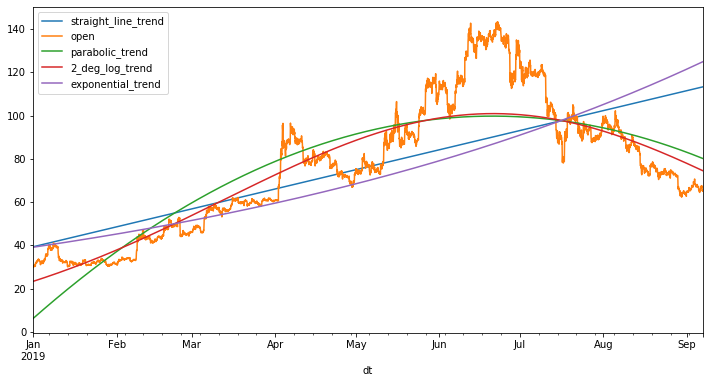

In [118]:
# plotting trend valueswith actual values
ltc.plot_data(col=['straight_line_trend','open', 'parabolic_trend', '2_deg_log_trend', 'exponential_trend'], subset =True)

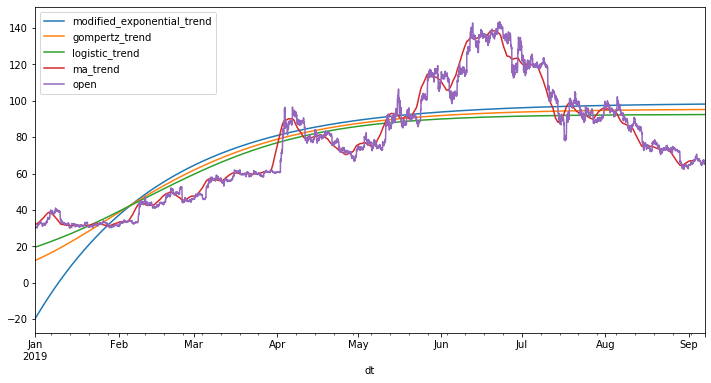

In [119]:
# plotting trend valueswith actual values
ltc.plot_data(col=['modified_exponential_trend','gompertz_trend','logistic_trend' ,'ma_trend','open'], subset =True)

## Seasonality

Ratio to moving average

In [221]:
ltc.trend(col = 'open', method = "ma", subset = True, period = 24)

In [222]:
ltc.seasonality(col = 'open', method = 'ratio to ma',trend= 'ma_trend' ,subset = True)

---Check self.seasonal---


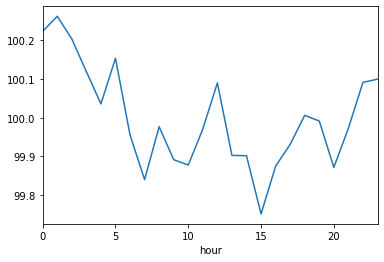

In [193]:
ltc.seasonal.plot()

Link Relative

In [253]:
ltc.seasonality(col='open', method = 'link relative', trend= None, subset = True)

---Check self.seasonal---


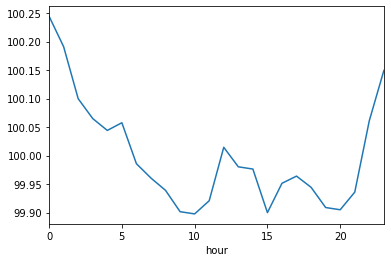

In [247]:
ltc.seasonal.plot()

Method Of Simple Averages

In [268]:
ltc.seasonality(col = 'open', method = 'simple averages',trend = None, subset = True)

---Check self.seasonal---


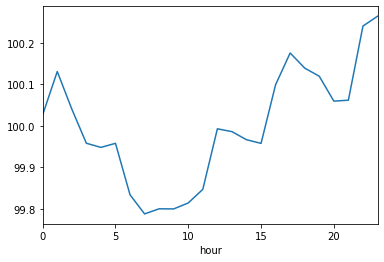

In [210]:
ltc.seasonal.plot()

Ratio to trend

In [236]:
ltc.trend(col = 'open', method = "2_deg_log", subset = True, period = 24)

In [237]:
ltc.seasonality(col='open', method = 'ratio to trend',trend='2_deg_log_trend', subset = True)

---Check self.seasonal---


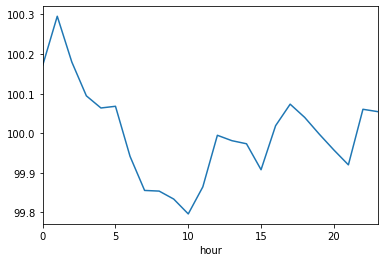

In [186]:
ltc.seasonal.plot()

### Deseasonalize

In [ ]:
ltc.seasonality(col = 'open', method = 'simple averages',trend = None, subset = True)

In [269]:
ltc.deseasonalize('open',subset = True)

In [272]:
ltc.sub

,close,high,low,open,time,volumefrom,volumeto,year,deseasonalized_open
dt,,,,,,,,,
2019-09-07 00:00:00+00:00,65.31,65.49,65.09,65.44,1567814400,2647.04,176114.00,2019,65.422650
2019-09-06 23:00:00+00:00,65.44,65.52,64.94,65.11,1567810800,4519.61,298207.02,2019,64.938626
2019-09-06 22:00:00+00:00,65.11,65.51,65.07,65.50,1567807200,5899.30,384453.27,2019,65.343037
2019-09-06 21:00:00+00:00,65.50,65.50,64.88,65.11,1567803600,6109.94,398098.79,2019,65.069974
2019-09-06 20:00:00+00:00,65.11,65.34,64.08,65.34,1567800000,30096.39,1943477.44,2019,65.301275
2019-09-06 19:00:00+00:00,65.34,65.57,64.69,65.42,1567796400,10074.74,656415.33,2019,65.342076
2019-09-06 18:00:00+00:00,65.42,65.61,65.29,65.61,1567792800,12937.99,846281.84,2019,65.519002
2019-09-06 17:00:00+00:00,65.61,67.31,64.85,67.31,1567789200,48372.22,3182388.39,2019,67.192203
2019-09-06 16:00:00+00:00,67.31,67.68,66.86,67.01,1567785600,9363.32,628678.26,2019,66.943768


-----

### Rough